# Import necessary dependencies and settings

In [1]:
import pandas as pd
import seaborn as sn
import numpy as np
import matplotlib.pyplot as plt
import nltk

import sys
import os
from pyprojroot import here
sys.path.append(os.path.join(here(), 'src'))
import cleaning

%matplotlib inline

# Loading the Data

In [2]:
header_list = ["id", "label", "statement", "subject", "speaker", 
               "speaker_job", "speaker_state", "speaker_affiliation", 
               "barely_true_counts", "false_counts", "half_true_counts", 
               "mostly_true_counts", "pants_on_fire_counts", "context"]

train_data = pd.read_csv('../data/raw/train.tsv', sep='\t',  names=header_list)
val_data = pd.read_csv('../data/raw/valid.tsv', sep='\t',  names=header_list)
test_data = pd.read_csv('../data/raw/test.tsv', sep='\t', names=header_list)

# Dropping nonmandatory features

In [3]:
print(train_data.columns.to_list())
# print(val_data.columns.to_list())
# print(test_data.columns.to_list())

['id', 'label', 'statement', 'subject', 'speaker', 'speaker_job', 'speaker_state', 'speaker_affiliation', 'barely_true_counts', 'false_counts', 'half_true_counts', 'mostly_true_counts', 'pants_on_fire_counts', 'context']


Training, Validation and test datasets contain 14 features such as id, label, statement and speaker, speaker_job, speaker_state etc.
To build a fake news prediction model, we don't need speaker-related information as the speaker will not always be consistent. It will keep on changing. So, we are just keeping "statement" and "label".

In [4]:
train = train_data[['label', 'statement']]
val = val_data[['label', 'statement']]
test = test_data[['label', 'statement']]

# Data analysis

In [5]:
#data observation
def data_obs():
    """
    Function to check the shape and first 5 rows of the datasets
    """
    print("training dataset size:")
    print(train.shape)
    print(train.head())

    print("validation dataset size:")
    print(val.shape)
    print(val.head())
    
    print("test dataset size:")
    print(test.shape)
    print(test.head())

In [6]:
data_obs()

training dataset size:
(10240, 2)
         label                                          statement
0        false  Says the Annies List political group supports ...
1    half-true  When did the decline of coal start? It started...
2  mostly-true  Hillary Clinton agrees with John McCain "by vo...
3        false  Health care reform legislation is likely to ma...
4    half-true  The economic turnaround started at the end of ...
validation dataset size:
(1284, 2)
         label                                          statement
0  barely-true  We have less Americans working now than in the...
1   pants-fire  When Obama was sworn into office, he DID NOT u...
2        false  Says Having organizations parading as being so...
3    half-true     Says nearly half of Oregons children are poor.
4    half-true  On attacks by Republicans that various program...
test dataset size:
(1267, 2)
        label                                          statement
0        true  Building a wall on the U.S.-Me

In [7]:
print(test.iloc[6]['statement'])

Says that Tennessee law requires that schools receive half of proceeds -- $31 million per year -- from a half-cent increase in the Shelby County sales tax.


# Data Quality Check

**The info() method prints information about a DataFrame including the index dtype and columns, non-null values and memory usage.**

In [8]:
#data integrity check (missing label values)
#none of the datasets contains missing values therefore no cleaning required
def data_qualityCheck():
    
    print("Checking train data qualitites...")
    print(train.isnull().sum())
    print(train.info())
        
    print("check finished...")
    print()

    print("Checking test data qualitites...")
    print(test.isnull().sum())
    print(test.info())
    print("check finished...")
    print()
    
    print("Checking validation data qualitites...")
    print(val.isnull().sum())
    print(val.info())

In [9]:
data_qualityCheck()

Checking train data qualitites...
label        0
statement    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      10240 non-null  object
 1   statement  10240 non-null  object
dtypes: object(2)
memory usage: 160.1+ KB
None
check finished...

Checking test data qualitites...
label        0
statement    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1267 entries, 0 to 1266
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   label      1267 non-null   object
 1   statement  1267 non-null   object
dtypes: object(2)
memory usage: 19.9+ KB
None
check finished...

Checking validation data qualitites...
label        0
statement    0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1284 entries, 0 to 1283
Data columns (total 2 columns):
 #

There are not a single null values or missing data. We are good to go.

# Label Distribution

## Labels by count

In [10]:
len(set(train_data['label'].values))

6

In [11]:
print(train_data['label'].value_counts())
print(val_data['label'].value_counts())
print(test_data['label'].value_counts())

half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64
false          263
mostly-true    251
half-true      248
barely-true    237
true           169
pants-fire     116
Name: label, dtype: int64
half-true      265
false          249
mostly-true    241
barely-true    212
true           208
pants-fire      92
Name: label, dtype: int64


In [12]:
# #distribution of classes for prediction
# def create_distribution(dataFile):
    
#     return sn.countplot(x='label', data=dataFile, palette='hls')

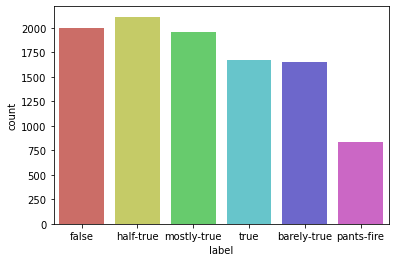

In [13]:
create_distribution(train)

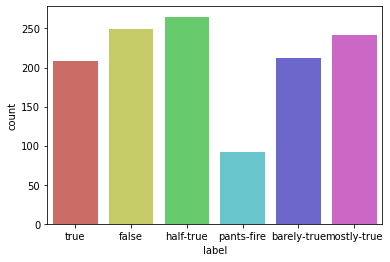

In [14]:
create_distribution(test)

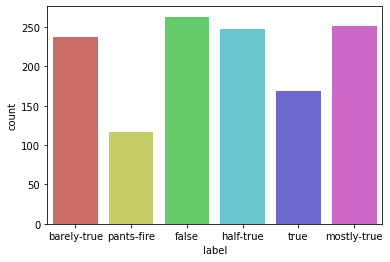

In [15]:
create_distribution(val)

From the above distribution plots, it is evident, majority of the news articles are falling under 'half-true','mostly true' and 'false'lables.

Using Pandas info() method, we see that there is not any null values in the datasets. 

## Mapping the lables into 'True' and 'False'

1. True -- True
2. Mostly-true -- True
3. Half-true -- True
4. Barely-true -- False
5. False -- False
6. Pants-fire -- False

In [16]:
# def map_lables(train,test,val):
#     labels_dict = {'true': 'true','mostly-true': 'true',
#                    'half-true':'true', 'false':'false', 
#                    'barely-true':'false','pants-fire':'false'}
    
#     train= train.replace({"label": labels_dict})[['label','statement']]
#     test = test.replace({"label": labels_dict})[['label','statement']]
#     val = val.replace({"label": labels_dict})[['label','statement']]
#     display(train.head(3), test.head(3), val.head(3))
    
#     return train, test, val  

In [17]:
train_news, test_news, val_news = map_lables(train,test,val)

AxesSubplot(0.125,0.125;0.775x0.755)


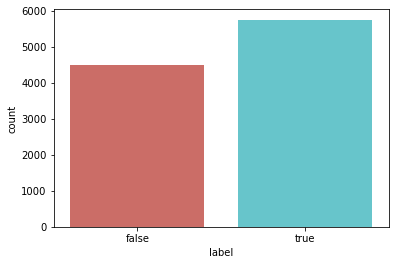

In [18]:
print(create_distribution(train_news))

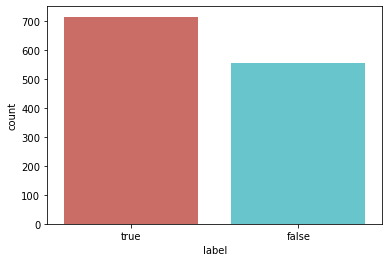

In [19]:
create_distribution(test_news)

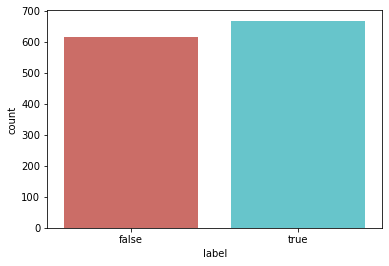

In [20]:
create_distribution(val_news)

By calling distribution funtion on the mapped datasets, we can see that training, test and valid data seems to be failry evenly distributed between the classes.

## Finding distribution of Statement lengths in News Articles

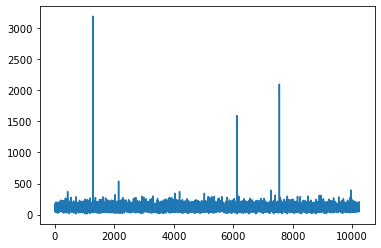

In [21]:
train_line_lengths = [len(statement) for statement in train_news['statement']]
plt.plot(train_line_lengths)
plt.show()

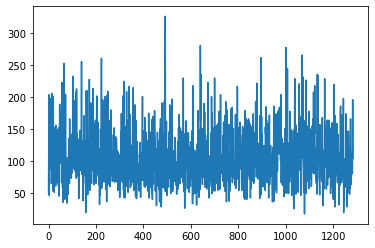

In [22]:
val_line_lengths = [len(statement) for statement in val_news['statement']]
plt.plot(val_line_lengths)
plt.show()

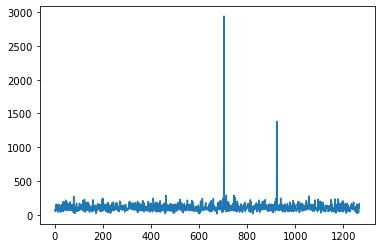

In [23]:
test_line_lengths = [len(statement) for statement in test_news['statement']]
plt.plot(test_line_lengths)
plt.show()

**From the distribution above, it is clear that there are some outliers i.e. statements with a quite high length. Lets get into more details and filter the statements with the length higher than 500.**

In [24]:
train_news['len'] = [len(statement) for statement in train_news['statement']]

In [25]:
train_news[(train_news['len'] > 500)] 

,label,statement,len
1280,true,"Hospitals, doctors, MRIs, surgeries and so for...",3192
2142,false,The fact is that although we have had a presid...,538
6119,true,Georgia has the most restrictive ballot access...,1592
7550,false,The vast majority of the money I got was from ...,2099


In [26]:
train_news

,label,statement,len
0,false,Says the Annies List political group supports ...,82
1,true,When did the decline of coal start? It started...,141
2,true,"Hillary Clinton agrees with John McCain ""by vo...",105
3,false,Health care reform legislation is likely to ma...,78
4,true,The economic turnaround started at the end of ...,54
...,...,...,...
10235,true,There are a larger number of shark attacks in ...,90
10236,true,Democrats have now become the party of the [At...,78
10237,true,Says an alternative to Social Security that op...,176
10238,false,On lifting the U.S. Cuban embargo and allowing...,62


In [27]:
train_news.iloc[7550]['statement']

'The vast majority of the money I got was from small donors all across the country.\'\'\tcampaign-finance\tbarack-obama\tPresident\tIllinois\tdemocrat\t70\t71\t160\t163\t9\tan interview with CNBC\'s John Harwood \n5802.json\ttrue\tThe Democrat-controlled Senate, it hasnt passed a budget in more than 1,000 days.\tdeficit,federal-budget,job-accomplishments\tjohn-boehner\tSpeaker of the House of Representatives\tOhio\trepublican\t13\t22\t11\t4\t2\ta video address\n6153.json\thalf-true\tThe median income in America has dropped by 10 percent in the last four years.\teconomy,income,jobs\tmitt-romney\tFormer governor\tMassachusetts\trepublican\t34\t32\t58\t33\t19\ta speech\n6515.json\tbarely-true\tSays U.S. Senate hopeful Tammy Baldwin voted for a $1 trillion stimulus bill that included a wasteful $800,000 to replace light bulbs.\tenergy,federal-budget,stimulus\tcrossroads-gps\tConservative advocacy group\t\trepublican\t9\t1\t4\t1\t2\ta television ad\n385.json\ttrue\tSays Clinton did not read

In [28]:
test_news['len'] = [len(statement) for statement in test_news['statement']]

## Drop the rows with incorrect parsing.

In [29]:
train_news = train_news[train_news['len'] < 500]
test_news = test_news[test_news['len'] < 500]

**So, the data was not parsed correctly. For now, I will be just ignoring these rows. More data cleaning will be performed later in the process.** 

### Saving the processed version of the datasets.

In [30]:
train_news.to_csv('../data/processed/train.csv', index=False)
val_news.to_csv('../data/processed/val.csv', index=False)
test_news.to_csv('../data/processed/test.csv', index=False)                          